In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
import os

#### Extracting original healthy data used to train the TFLite micro model


In [2]:
folder = "C:/Users/jared/Desktop/EG3301R_Repos/collected_data/datacollect/LiveData/*"

# get all files in folder
files = glob.glob(folder + '*.csv')

dataset_live_list = []

# num_files = 0
for file in files:
    # if (num_files == 20):
    #     break
    
    # num_files += 1
    # read data from file
    data = pd.read_csv(file, header=None)
    
    # remove first column
    data = data.drop(data.columns[0], axis=1)
    
    # next 6 columns are the vibration data
    data = data.iloc[:, 0:6].values  # Convert to numpy array

    # Calculate the number of chunks (100-row segments)
    num_chunks = data.shape[0] // 100
    
    for i in range(num_chunks):
        chunk = data[i*100:(i+1)*100, :]
        dataset_live_list.append(chunk.transpose()[np.newaxis, :])

# Convert list to numpy array
dataset_live = np.concatenate(dataset_live_list, axis=0)

print("Dataset live shape:", dataset_live.shape)

# label datasets as "LiveData"

dataset_live_labels = np.full((dataset_live.shape[0]), 'LiveData')

print("Dataset live labels shape", dataset_live_labels.shape)


# remove NAN rows along with their corresponding labels

# find the rows with NAN
nan_rows = np.argwhere(np.isnan(dataset_live))
print("Nan_rows shape: ", nan_rows.shape)
print("Number of nan_rows", nan_rows)

# remove the rows with NAN
dataset_live = np.delete(dataset_live, nan_rows[:, 0], axis=0)
dataset_live_labels = np.delete(dataset_live_labels, nan_rows[:, 0], axis=0)

# check that there are no more NAN rows
nan_rows = np.argwhere(np.isnan(dataset_live))
print("nan_rows shape: " ,nan_rows.shape)
print("number of nan_rows: ", nan_rows)

# check that the shapes are the same
print("Dataset live shape: ", dataset_live.shape)
print("Dataset live labels shape: ", dataset_live_labels.shape)

Dataset live shape: (33630, 6, 100)
Dataset live labels shape (33630,)
Nan_rows shape:  (246, 3)
Number of nan_rows [[10970     0     0]
 [10970     1     0]
 [10970     2     0]
 [10970     3     0]
 [10970     4     0]
 [10970     5     0]
 [23655     0    60]
 [23655     0    61]
 [23655     0    62]
 [23655     0    63]
 [23655     0    64]
 [23655     0    65]
 [23655     0    66]
 [23655     0    67]
 [23655     0    68]
 [23655     0    69]
 [23655     0    70]
 [23655     0    71]
 [23655     0    72]
 [23655     0    73]
 [23655     0    74]
 [23655     0    75]
 [23655     0    76]
 [23655     0    77]
 [23655     0    78]
 [23655     0    79]
 [23655     0    80]
 [23655     0    81]
 [23655     0    82]
 [23655     0    83]
 [23655     0    84]
 [23655     0    85]
 [23655     0    86]
 [23655     0    87]
 [23655     0    88]
 [23655     0    89]
 [23655     0    90]
 [23655     0    91]
 [23655     0    92]
 [23655     0    93]
 [23655     0    94]
 [23655     0    95]
 [

#### Extracting data collected from RPI


In [3]:
def newDataReader(datapath):
    
    with open(datapath, 'r') as file:
        lines = file.readlines()

    data_blocks = []  # to store individual data blocks of 1000 lines each

    i = 0
    while i < len(lines):
        line = lines[i].strip()
        if '----' in line:
            i += 1
            continue
        else:
            start = i
            # Find the end of this block (either another dash line or end of file)
            while i < len(lines) and '----' not in lines[i]:
                i += 1
            end = i
            
            block = lines[start:end]
            data = [list(map(float, item.split(','))) for item in block if ',' in item]  # convert string to list of floats
            
            # Check the length of data, adjust and log if necessary
            if len(data) < 1000:
                padding = [[0.0] * 9 for _ in range(1000 - len(data))]
                data.extend(padding)
                print(f"Data block starting at line {start} has less than 1000 lines. Padding with zeros.")
            elif len(data) > 1000:
                data = data[:1000]
                print(f"Data block starting at line {start} has more than 1000 lines. Truncating to 1000.")
            
            data_blocks.append(data)

    # Convert list of data blocks into a 3D numpy array
    datasets_array = np.array(data_blocks)
    
    return datasets_array


folder = "c:/Users/jared/Desktop/EG3301R_Repos/collected_data/datacollect/"

dataset1_label = ["Healthy2", "Healthy3", "Loose2", "Loose3", "Cavitation", "Cavitation2", "Cavitation3", "Cavitation10"]

all_data = []
all_labels = []

for label in dataset1_label:
    files = glob.glob(folder + label + "/*")
    Dataset = []
    num_files = 0
    for file in files:
        if (num_files == 20):
            break
        
        num_files += 1
        print(file)
        data_segment = newDataReader(file)
        Dataset.append(data_segment)
    Dataset_np = np.concatenate(Dataset, axis=0)  # shape becomes (9, total_n_for_this_label, 1000)
    Dataset_np = np.transpose(Dataset_np, (0, 2, 1))  # shape becomes (total_n_for_this_label, 9, 1000)

    # Append to main data list
    all_data.append(Dataset_np)
    
    # Create and append labels for this data
    labels_for_this_data = [label] * Dataset_np.shape[0]  # repeat the label 'total_n_for_this_label' times
    all_labels.extend(labels_for_this_data)

# remove last 3 columns
all_data = [data[:, :6, :] for data in all_data]

# Combine all data segments
all_data_np = np.concatenate(all_data, axis=0)  # shape: (total_n, 9, 1000)

# Convert all labels to numpy array for consistency
all_labels_np = np.array(all_labels)

c:/Users/jared/Desktop/EG3301R_Repos/collected_data/datacollect/Healthy2\2023-09-12T16-00-00.txt
c:/Users/jared/Desktop/EG3301R_Repos/collected_data/datacollect/Healthy2\2023-09-12T17-00-00.txt
c:/Users/jared/Desktop/EG3301R_Repos/collected_data/datacollect/Healthy2\2023-09-12T18-00-00.txt
c:/Users/jared/Desktop/EG3301R_Repos/collected_data/datacollect/Healthy2\2023-09-12T19-00-00.txt
c:/Users/jared/Desktop/EG3301R_Repos/collected_data/datacollect/Healthy2\2023-09-12T20-00-00.txt
c:/Users/jared/Desktop/EG3301R_Repos/collected_data/datacollect/Healthy2\2023-09-12T21-00-00.txt
c:/Users/jared/Desktop/EG3301R_Repos/collected_data/datacollect/Healthy2\2023-09-12T22-00-01.txt
c:/Users/jared/Desktop/EG3301R_Repos/collected_data/datacollect/Healthy2\2023-09-12T23-00-00.txt
c:/Users/jared/Desktop/EG3301R_Repos/collected_data/datacollect/Healthy2\2023-09-13T00-00-00.txt
c:/Users/jared/Desktop/EG3301R_Repos/collected_data/datacollect/Healthy2\2023-09-13T01-00-00.txt
c:/Users/jared/Desktop/EG3301R

In [4]:
print(all_data_np.shape)  # This should give (total_n, 9, 1000)
print(all_labels_np.shape)  # This should give (total_n,)\


(44065, 6, 1000)
(44065,)


In [5]:
# to convert to 100 sized segments

new_data = []

for sample in all_data_np:
    for i in range(0, 1000, 100):
        new_data.append(sample[:, i:i+100])

# Convert new_data list to numpy array
all_data_np_reshaped = np.array(new_data)

# Adjust labels
all_labels_np_reshaped = np.repeat(all_labels_np, 10)

# erase new_data
del new_data

# add live data to the end of the dataset

all_data_np_reshaped = np.concatenate((all_data_np_reshaped, dataset_live), axis=0)
all_labels_np_reshaped = np.concatenate((all_labels_np_reshaped, dataset_live_labels), axis=0)

print(all_data_np_reshaped.shape)
print(all_labels_np_reshaped.shape)

(474278, 6, 100)
(474278,)


In [6]:
# normalize the data for each axis for the first 6 axes from -1 to 1
# the last 3 axes are already in the range of 0 to 1
# use MinMaxScaler from sklearnW
data_to_use = all_data_np_reshaped
labels_to_use = all_labels_np_reshaped

# clear reshaped data
del all_data_np_reshaped
del all_labels_np_reshaped


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
for i in range(6):
    data_to_use[:, i, :] = scaler.fit_transform(data_to_use[:, i, :])

In [7]:
# make the true labels, Healthy, Healthy2, Healthy3 are all Healthy, Loose, Loose2 are all Loose, Cavitation, Cavitation2, Cavitation3 are all Cavitation
true_labels = labels_to_use.copy()

# true_labels[true_labels == "Healthy2"] = "Healthynew"
# true_labels[true_labels == "Healthy3"] = "Healthynew"

# true_labels[true_labels == "Loose2"] = "Loosenew"
# true_labels[true_labels == "Loose3"] = "Loosenew"

# true_labels[true_labels == "Cavitation2"] = "Cavitation"
# true_labels[true_labels == "Cavitation3"] = "Cavitation"

In [8]:
# choose one axis so that we can do ml on it
import seaborn as sns

# all_data_oneaxis = all_data_np[:, 0, :]  # shape: (total_n, 1000)

# create new dataframe that consists of the combination of the first 100 data points of each segment for the first 6 segments resulting in (total_n, 600)
all_data_concat = np.concatenate((data_to_use[:, 0,:100], data_to_use[:, 1, :100], data_to_use[:, 2, :100], data_to_use[:, 3, :100], data_to_use[:, 4, :100], data_to_use[:, 5, :100]), axis=1)
print(all_data_concat.shape)


# remove Healthy and Loose from the data

# all_data_concat = all_data_concat[true_labels != "Healthy"]
# true_labels = true_labels[true_labels != "Healthy"]
# all_data_concat = all_data_concat[true_labels != "Loose"]
# true_labels = true_labels[true_labels != "Loose"]

print(all_data_concat.shape)
print(true_labels.shape)

(474278, 600)
(474278, 600)
(474278,)


In [9]:
# USE THIS CELL TO BALANCE THE DATA

# want to make sure data is balanced, cut the data so that each label has the same number of data points
# first find the label with the least number of data points
unique, counts = np.unique(true_labels, return_counts=True)
print(unique)
print(counts)

# now, cut the data so that each label has the same number of data points while also spreading the data points out evenly
# first, find the number of data points to cut
min_count = min(counts)
print(min_count)

# now, cut the data
all_data_concat_cut = np.empty((0, 600))
true_labels_cut = np.empty((0))

# cut such that the data is spread out evenly
for i in range(len(unique)):
    toadd = all_data_concat[true_labels == unique[i]]
    toadd = toadd[::(int)(len(toadd)/min_count)]
    toadd = toadd[:min_count]
    all_data_concat_cut = np.concatenate((all_data_concat_cut, toadd), axis=0)
    toadd = true_labels[true_labels == unique[i]]
    toadd = toadd[::(int)(len(toadd)/min_count)]
    toadd = toadd[:min_count]
    true_labels_cut = np.concatenate((true_labels_cut, toadd), axis=0)

print(all_data_concat_cut.shape)
print(true_labels_cut.shape)

unique, counts = np.unique(true_labels_cut, return_counts=True)
print(unique)
print(counts)

all_data_concat = all_data_concat_cut
true_labels = true_labels_cut

all_data_concat_cut = None
true_labels_cut = None



['Cavitation' 'Cavitation10' 'Cavitation2' 'Cavitation3' 'Healthy2'
 'Healthy3' 'LiveData' 'Loose2' 'Loose3']
[55070 55080 55080 55080 55090 55090 33628 55070 55090]
33628
(302652, 600)
(302652,)
['Cavitation' 'Cavitation10' 'Cavitation2' 'Cavitation3' 'Healthy2'
 'Healthy3' 'LiveData' 'Loose2' 'Loose3']
[33628 33628 33628 33628 33628 33628 33628 33628 33628]


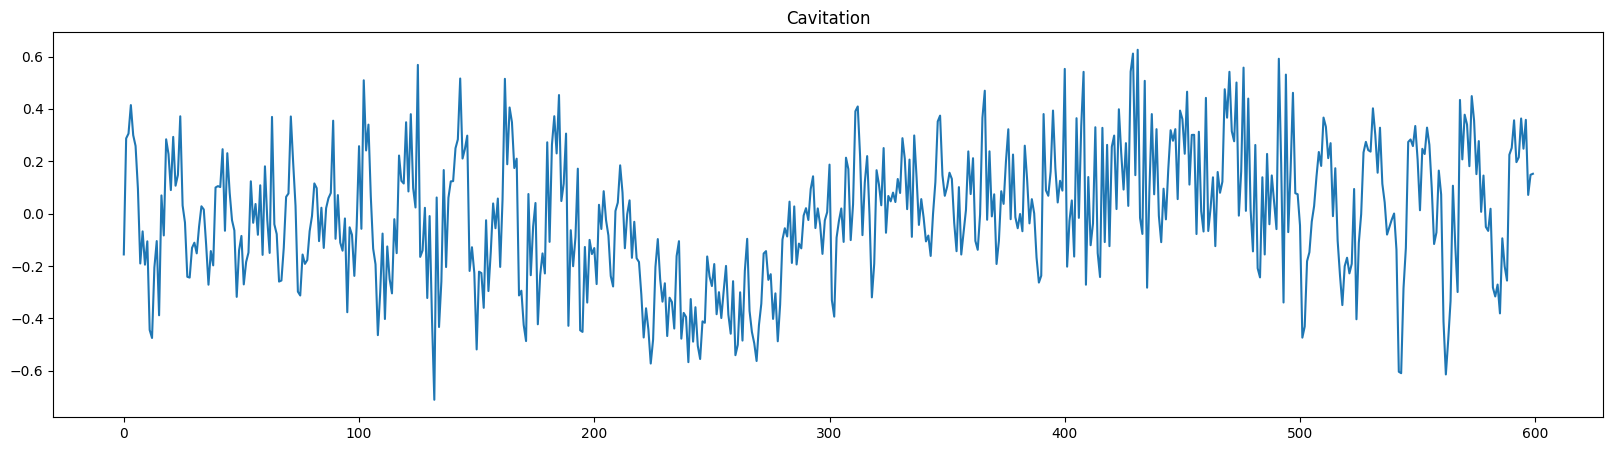

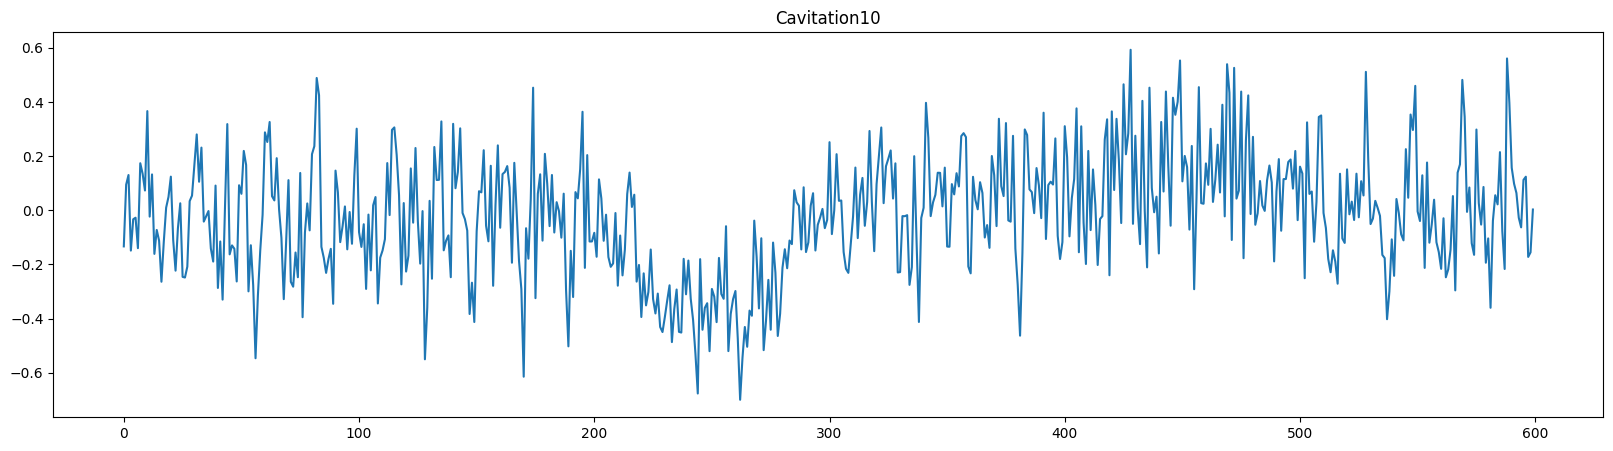

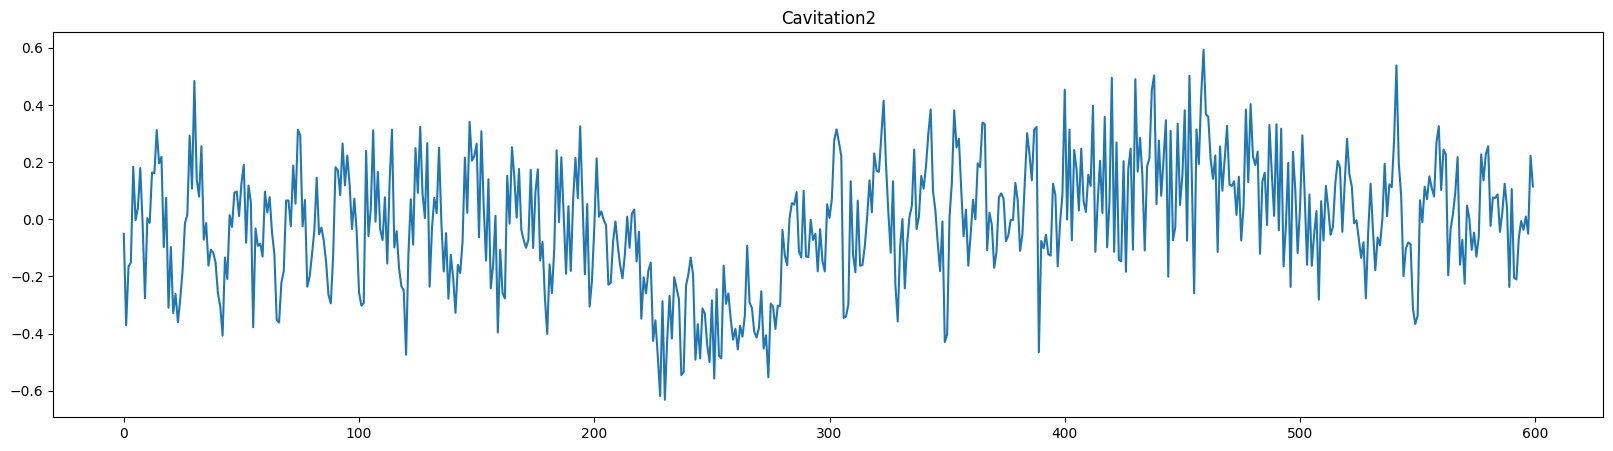

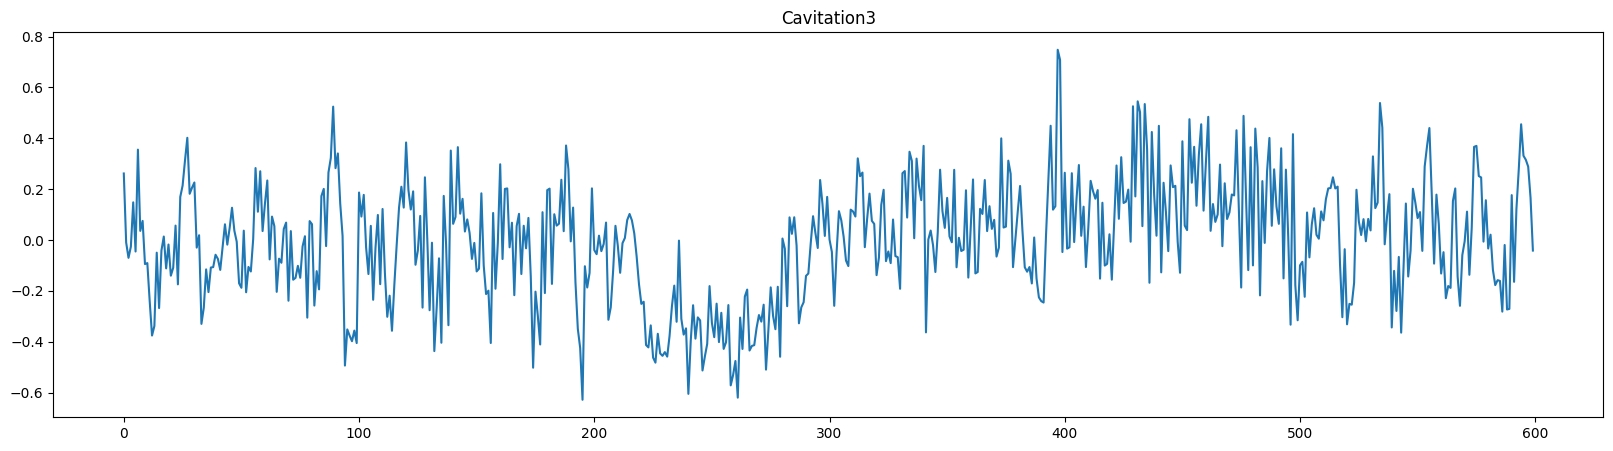

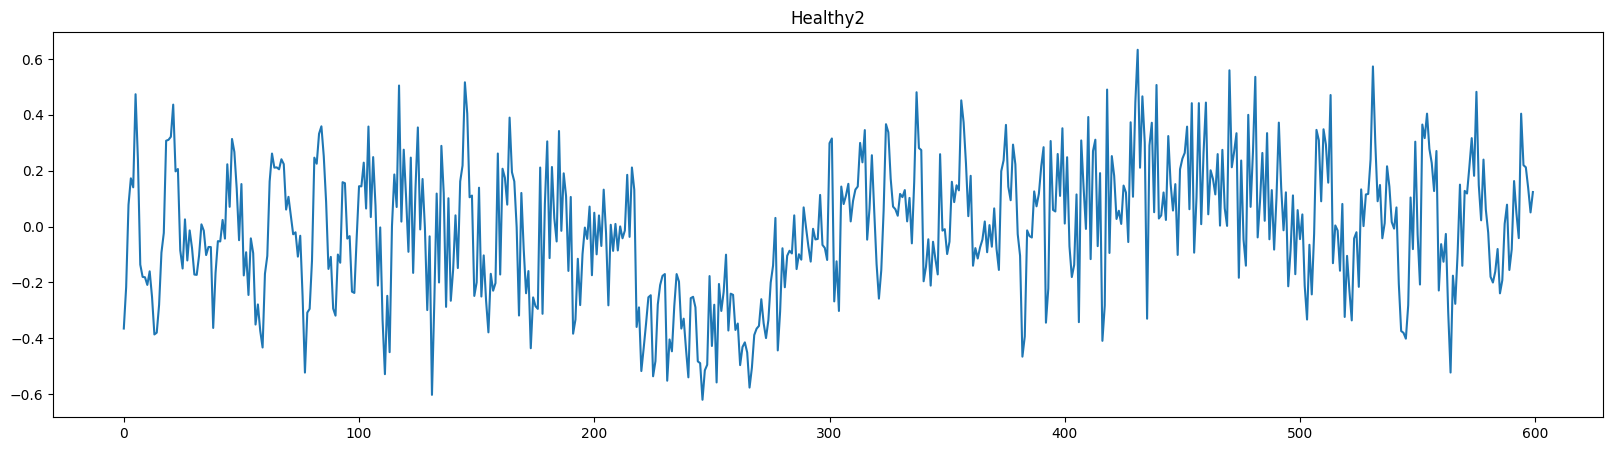

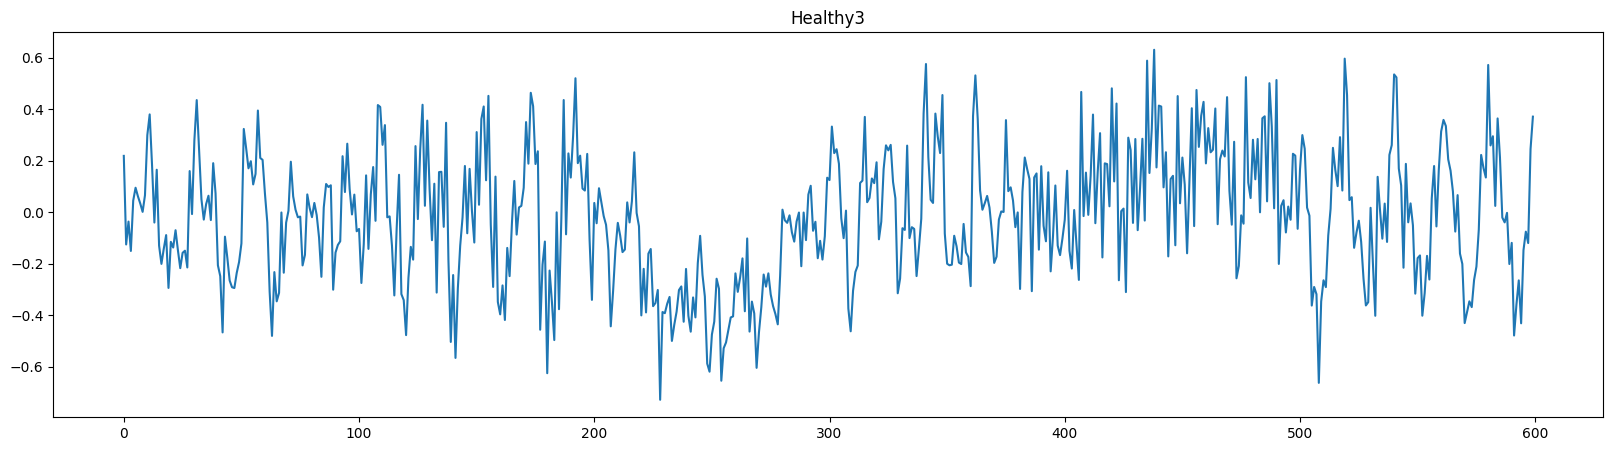

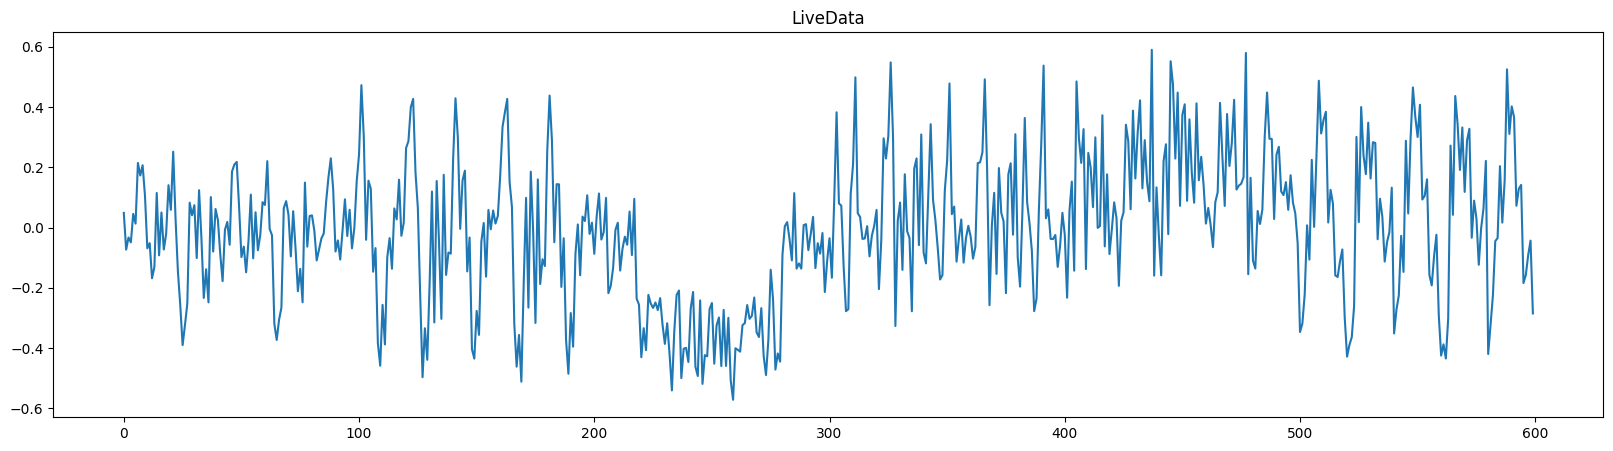

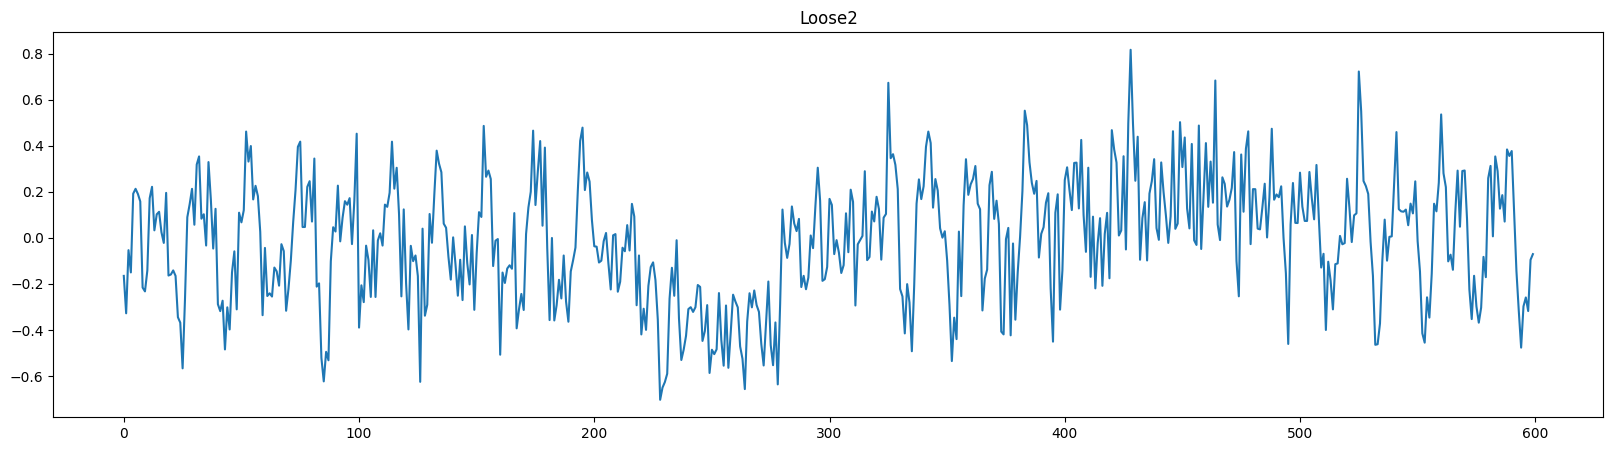

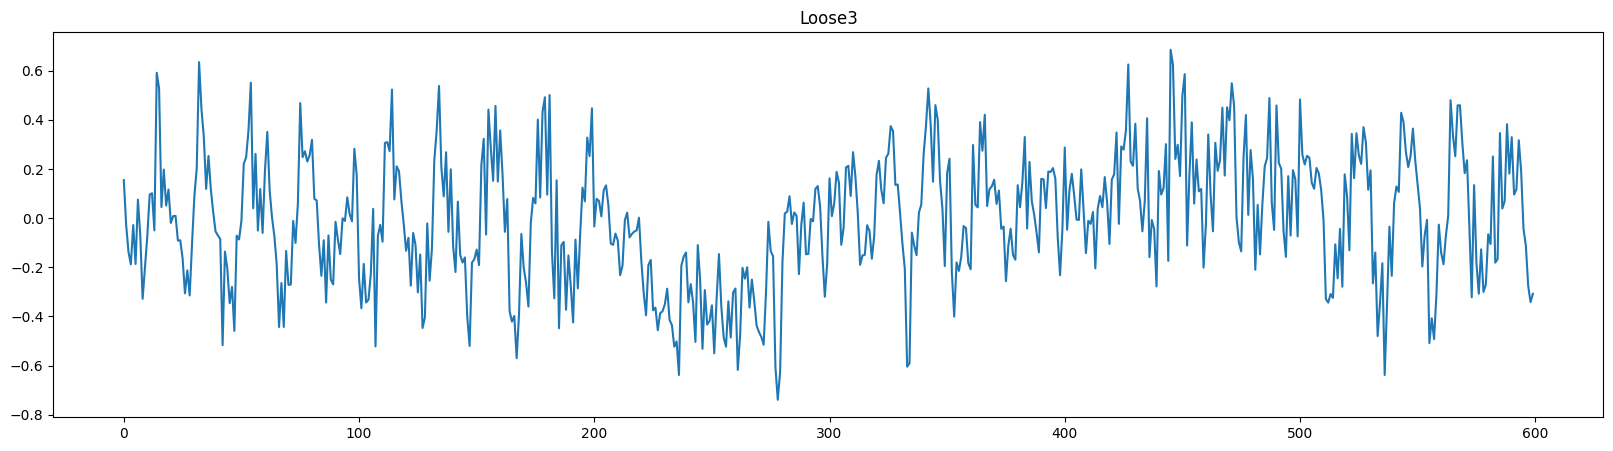

In [10]:
# Visualize the data for each label and segment
for i in range(len(unique)):
    plt.figure(figsize=(20, 5))
    plt.title(unique[i])
    plt.plot(all_data_concat[true_labels == unique[i], :][0])
    plt.show()

In [11]:
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# clear the tensorflow runtime
# tf.keras.backend.clear_session()

# disable gpu for training
# tf.config.set_visible_devices([], 'GPU')
# enable gpu for training
# gpus = tf.config.list_physical_devices('GPU')
# tf.config.set_visible_devices(gpus[0], 'GPU')

# print(tf.config.list_physical_devices('GPU'))

X = all_data_concat
Y = true_labels

X_training = X[np.isin(Y, ['Loose2', 'Cavitation2', 'Cavitation', 'Healthy3', 'Healthy2', 'Cavitation3'])]
Y_training = Y[np.isin(Y, ['Loose2', 'Cavitation2', 'Cavitation', 'Healthy3', 'Healthy2', 'Cavitation3'])]

# change the labels from Healthy2 --> Healthy, Loose2 --> Loose, Cavitation2 --> Cavitation
Y_training[Y_training == "Healthy2"] = "Healthy"
Y_training[Y_training == "Loose2"] = "Loose"
Y_training[Y_training == "Cavitation2"] = "Cavitation"

Y_training[Y_training == "Healthy3"] = "Healthy"
# Y_training[Y_training == "Loose3"] = "Loose"
Y_training[Y_training == "Cavitation3"] = "Cavitation"


# # take out Healthy3, Loose3, Cavitation3 as hidden data
# X_hidden = X[np.isin(Y, ['Healthy3', 'Loose3', 'Cavitation3'])]
# Y_hidden = Y[np.isin(Y, ['Healthy3', 'Loose3', 'Cavitation3'])]

# # change the labels from Healthy3 --> Healthy, Loose3 --> Loose, Cavitation3 --> Cavitation
# Y_hidden[Y_hidden == "Healthy3"] = "Healthy"
# Y_hidden[Y_hidden == "Loose3"] = "Loose"
# Y_hidden[Y_hidden == "Cavitation3"] = "Cavitation"

# take out Healthy3, Loose3, Cavitation3 as hidden data
X_hidden = X[np.isin(Y, ['LiveData', 'Loose3', 'Cavitation10'])]
Y_hidden = Y[np.isin(Y, ['LiveData', 'Loose3', 'Cavitation10'])]

# change the labels from LiveData --> Healthy
Y_hidden[Y_hidden == "LiveData"] = "Healthy"
Y_hidden[Y_hidden == "Loose3"] = "Loose"
Y_hidden[Y_hidden == "Cavitation10"] = "Cavitation"


encoder = LabelEncoder()
encoder.fit(Y_training)
encoded_Y = encoder.transform(Y_training)
OHE_Y_training = to_categorical(encoded_Y)
encoded_Y_hidden = encoder.transform(Y_hidden)
OHE_Y_hidden = to_categorical(encoded_Y_hidden)

print(X_training.shape)
print(OHE_Y_training.shape)
print(X_hidden.shape)
print(OHE_Y_hidden.shape)
print(encoder.classes_)
# print(tf.config.list_physical_devices('GPU'))
# print(tf.config.list_logical_devices())


(201768, 600)
(201768, 3)
(100884, 600)
(100884, 3)
['Cavitation' 'Healthy' 'Loose']


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_training, OHE_Y_training, test_size=0.3, random_state=42, shuffle=True)



In [28]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten, Reshape
from keras.layers import Conv1D, MaxPooling1D, UpSampling1D
from keras.optimizers import Adam

# set early stopping criteria
from keras.callbacks import EarlyStopping

no_classes = len(encoder.classes_)

# normal autoencoder
# model = Sequential()
# model.add(Dense(1024, input_dim=X_train.shape[1], activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(512, activation='relu'))  
# model.add(Dropout(0.2))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(no_classes, activation='softmax'))

# model = Sequential()
# model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(128, activation='relu'))  
# model.add(Dropout(0.2))
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(no_classes, activation='softmax'))


# 1d convolutional classifier
cnn_classifier_model = Sequential()
cnn_classifier_model.add(Conv1D(filters=16, kernel_size=50, activation='elu', input_shape=(X_train.shape[1], 1)))
# cnn_classifier_model.add(Dropout(0.2))
cnn_classifier_model.add(Conv1D(filters=8, kernel_size=25, activation='elu'))
# cnn_classifier_model.add(Dropout(0.2))

cnn_classifier_model.add(MaxPooling1D(pool_size=4))
cnn_classifier_model.add(Flatten())
cnn_classifier_model.add(Dense(32, activation='elu'))
# cnn_classifier_model.add(Dropout(0.2))
cnn_classifier_model.add(Dense(no_classes, activation='softmax'))

cnn_classifier_model.summary()

cnn_classifier_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# For early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)



# 1d convolutional autoencoder
# cnn_autoencoder_model = Sequential()
# cnn_autoencoder_model.add(Conv1D(filters=16, kernel_size=50, activation='elu', input_shape=(X_train.shape[1], 1)))
# # cnn_autoencoder_model.add(Dropout(0.2))
# cnn_autoencoder_model.add(Conv1D(filters=8, kernel_size=25, activation='elu'))
# # cnn_autoencoder_model.add(Dropout(0.2))

# cnn_autoencoder_model.add(MaxPooling1D(pool_size=4))
# cnn_autoencoder_model.add(Flatten())
# cnn_autoencoder_model.add(Dense(32, activation='elu'))
# # cnn_autoencoder_model.add(Dropout(0.2))
# cnn_autoencoder_model.add(Dense(no_classes, activation='softmax'))

# cnn_autoencoder_model.summary()

# cnn_autoencoder_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# DENSE ONE TO TRY REDUCE MODEL SIZE
cnn_autoencoder_model_input_size = X_train.shape[1]
print(cnn_autoencoder_model_input_size)

cnn_autoencoder_model_input_layer = Input(shape=(cnn_autoencoder_model_input_size,))
cnn_autoencoder_model_encoder_layer = Sequential([
    Reshape((cnn_autoencoder_model_input_size, 1), input_shape=(cnn_autoencoder_model_input_size,)),
    Conv1D(filters=16, kernel_size=50, activation='elu'),
    # Dropout(0),
    Conv1D(filters=8, kernel_size=25, activation='elu'),
    # Dropout(0),
    MaxPooling1D(pool_size=4),
    Flatten(),
    Dense(32, activation='elu')
])

cnn_autoencoder_model_decoder_layer = Sequential([
    Dense(32, activation='elu'),
    # Dropout(0),
    UpSampling1D(size=4),
    Conv1D(filters=8, kernel_size=25, activation='elu'),
    # Dropout(0),
    Conv1D(filters=16, kernel_size=50, activation='elu'),
    # Dropout(0),
    Dense(cnn_autoencoder_model_input_size, activation='sigmoid')
])

cnn_autoencoder_model_encoder_layer = cnn_autoencoder_model_encoder_layer(cnn_autoencoder_model_input_layer)
cnn_autoencoder_model_decoder_layer = cnn_autoencoder_model_decoder_layer(cnn_autoencoder_model_encoder_layer)

cnn_autoencoder_model_autoencoder = Model(inputs=cnn_autoencoder_model_input_layer, outputs=cnn_autoencoder_model_decoder_layer)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode="auto")

cnn_autoencoder_model_autoencoder.summary()

# # Step 4: Train the autoencoder
cnn_autoencoder_model_autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# # Train the autoencoder with the EarlyStopping callback
# history = autoencoder.fit(
#     X_train, X_train,
#     epochs=100,
#     batch_size=256,
#     validation_data=(X_test, X_test),
#     callbacks=[early_stopping],
#     verbose=1
# )







Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_68 (Conv1D)          (None, 551, 16)           816       
                                                                 
 conv1d_69 (Conv1D)          (None, 527, 8)            3208      
                                                                 
 max_pooling1d_27 (MaxPooli  (None, 131, 8)            0         
 ng1D)                                                           
                                                                 
 flatten_24 (Flatten)        (None, 1048)              0         
                                                                 
 dense_61 (Dense)            (None, 32)                33568     
                                                                 
 dense_62 (Dense)            (None, 3)                 99        
                                                     

ValueError: Exception encountered when calling layer "sequential_36" (type Sequential).

Input 0 of layer "up_sampling1d_7" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 32)

Call arguments received by layer "sequential_36" (type Sequential):
  • inputs=tf.Tensor(shape=(None, 32), dtype=float32)
  • training=None
  • mask=None

In [19]:
history_cnn_classifier = cnn_classifier_model.fit(X_train,
                                                    y_train,
                                                    batch_size=3000,
                                                    epochs=5,
                                                    verbose=1,
                                                    shuffle=True,
                                                    callbacks=[es],
                                                    validation_data=(X_test, y_test))


Epoch 1/5
48/48 [==============================] - 84s 2s/step - loss: 0.0791 - accuracy: 0.9720 - val_loss: 0.0794 - val_accuracy: 0.9719
Epoch 2/5
48/48 [==============================] - 76s 2s/step - loss: 0.0729 - accuracy: 0.9743 - val_loss: 0.0688 - val_accuracy: 0.9764
Epoch 3/5
48/48 [==============================] - 75s 2s/step - loss: 0.0644 - accuracy: 0.9776 - val_loss: 0.0612 - val_accuracy: 0.9793
Epoch 4/5
48/48 [==============================] - 83s 2s/step - loss: 0.0575 - accuracy: 0.9801 - val_loss: 0.0540 - val_accuracy: 0.9822
Epoch 5/5
48/48 [==============================] - 85s 2s/step - loss: 0.0514 - accuracy: 0.9824 - val_loss: 0.0513 - val_accuracy: 0.9825


In [26]:
history_cnn_autoencoder = cnn_autoencoder_model.fit(X_train,
                                                    X_train,
                                                    batch_size=3000,
                                                    epochs=5,
                                                    verbose=1,
                                                    shuffle=True,
                                                    callbacks=[early_stopping],
                                                    validation_data=(X_test, X_test))

Epoch 1/5


ValueError: in user code:

    File "c:\Users\jared\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\jared\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\jared\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\jared\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1081, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\jared\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1139, in compute_loss
        return self.compiled_loss(
    File "c:\Users\jared\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\jared\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\jared\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\jared\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\losses.py", line 1608, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 3 and 600 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](sequential_27/dense_50/Softmax, IteratorGetNext:1)' with input shapes: [?,3], [?,600].


1892/1892 [==============================] - 10s 5ms/step


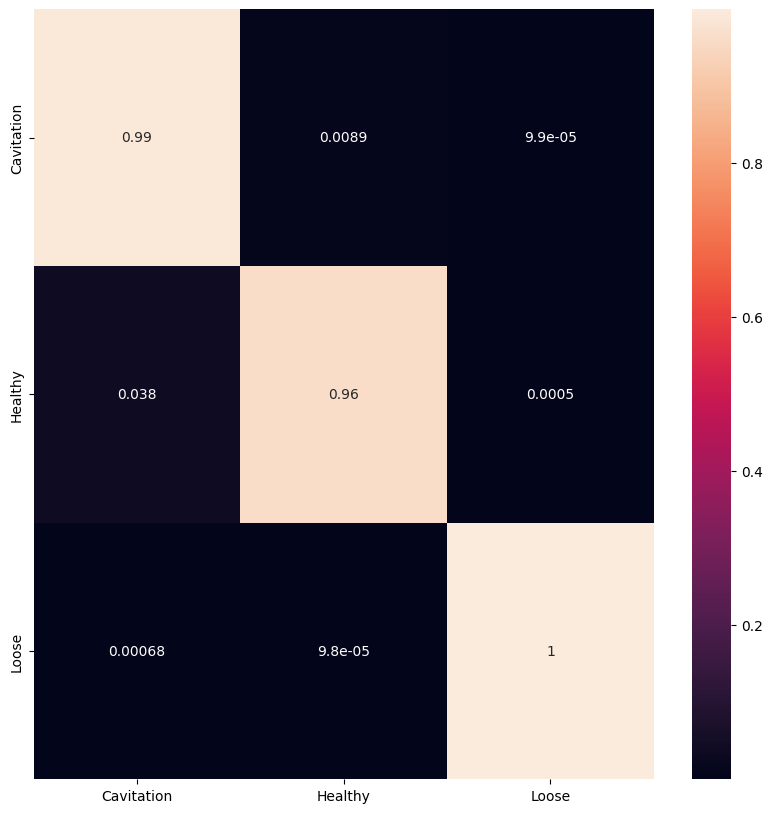

              precision    recall  f1-score   support

  Cavitation       0.97      0.99      0.98     30163
     Healthy       0.99      0.96      0.97     20128
       Loose       1.00      1.00      1.00     10240

    accuracy                           0.98     60531
   macro avg       0.99      0.98      0.99     60531
weighted avg       0.98      0.98      0.98     60531



In [20]:
def inv_Transform_result(y_pred, enc):
    y_pred = y_pred.argmax(axis=1)
    y_pred = enc.inverse_transform(y_pred)
    return y_pred

y_pred = model.predict(X_test)

y_pred = inv_Transform_result(y_pred, encoder)
y_compare = inv_Transform_result(y_test, encoder)

from sklearn.metrics import confusion_matrix, classification_report

plt.figure(figsize=(10,10))
cm = confusion_matrix(y_compare, y_pred, labels=encoder.classes_)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
f = sns.heatmap(cm, annot=True, xticklabels=encoder.classes_, yticklabels=encoder.classes_)

# confusion matrix with percentages

plt.show()

report = classification_report(y_compare, y_pred, labels=encoder.classes_)
print(report)

3153/3153 [==============================] - 17s 5ms/step


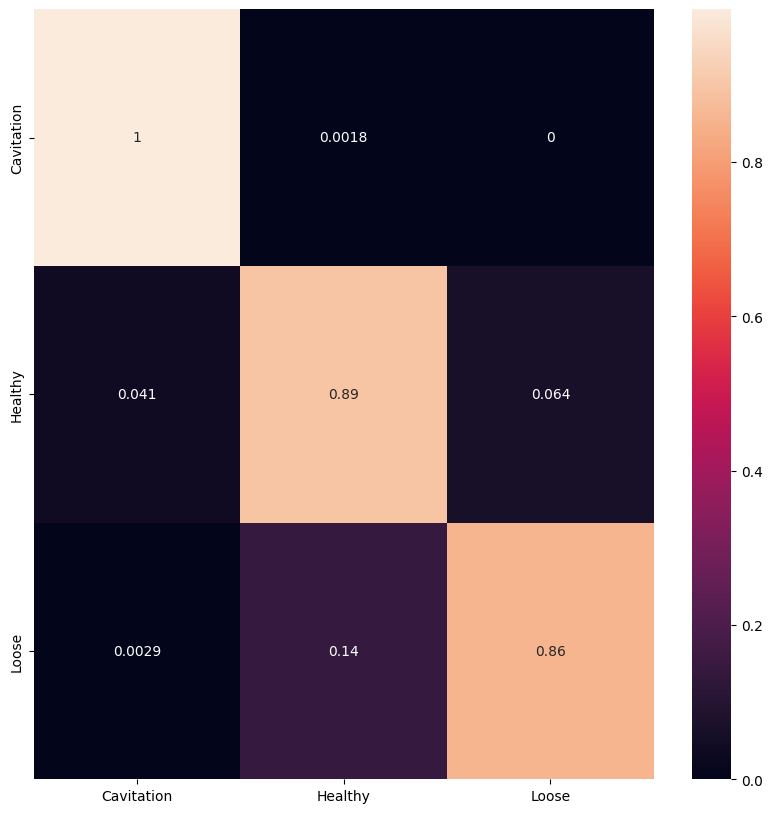

              precision    recall  f1-score   support

  Cavitation       0.96      1.00      0.98     33628
     Healthy       0.86      0.89      0.88     33628
       Loose       0.93      0.86      0.89     33628

    accuracy                           0.92    100884
   macro avg       0.92      0.92      0.92    100884
weighted avg       0.92      0.92      0.92    100884



In [21]:
# now test with the hidden data

y_pred = model.predict(X_hidden)

y_pred = inv_Transform_result(y_pred, encoder)
y_comp = inv_Transform_result(OHE_Y_hidden, encoder)

from sklearn.metrics import confusion_matrix, classification_report

plt.figure(figsize=(10,10))
cm = confusion_matrix(y_comp, y_pred, labels=encoder.classes_)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
f = sns.heatmap(cm, annot=True, xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.show()

report = classification_report(y_comp, y_pred, labels=encoder.classes_)
print(report)



In [33]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tinymlgen import port

from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential

# def cnn_representative_dataset():
#     for val in X_test:
#         val = np.expand_dims(val, axis=1)
#         yield [np.array(val, dtype=np.float32)]
        
def cnn_representative_dataset():
  for data in tf.data.Dataset.from_tensor_slices(X_test).batch(1).take(100):
    # Model has only one input so each data point has one element.
    data = np.expand_dims(data, axis=-1)
    yield [tf.dtypes.cast(data, tf.float32)]


# def cnn_representative_dataset():
#     for data in tf.data.Dataset.from_tensor_slices(X_test).batch(1).take(1000):
#         yield [tf.dtypes.cast(data, tf.float32)]
        

# Full integer quantization for healthy2 data (Y-axis)
fullint_converter_cnn = tf.lite.TFLiteConverter.from_keras_model(model)
fullint_converter_cnn.optimizations = [tf.lite.Optimize.DEFAULT]
fullint_converter_cnn.representative_dataset = cnn_representative_dataset
fullint_tflite_model_cnn = fullint_converter_cnn.convert()

# Save the models
open("cnn_fullint_quantized.tflite", "wb").write(fullint_tflite_model_cnn)


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp9qhtmgak\assets


INFO:tensorflow:Assets written to: C:\Users\jared\AppData\Local\Temp\tmp9qhtmgak\assets
c:\Users\jared\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\lite\python\convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


45688

#### Copy paste the following lines to run on bash cmdline

xxd -i Original_healthy_model_fullint_quantized.tflite > Original_healthy_model_fullint_quantized.cc  
xxd -i Healthy2_model_fullint_quantized.tflite > Healthy2_model_fullint_quantized.cc  
xxd -i Healthy3_model_fullint_quantized.tflite > Healthy3_model_fullint_quantized.cc
xxd -i cnn_fullint_quantized.tflite > cnn_fullint_quantized.cc


In [24]:
# For evaluating TFLite micro models against the test data
def evaluate_model_y_axis(interpreter, dataset, calculated_threshold):
    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    num_test_samples = dataset.shape[0]
    # print("Dataset shape: ", dataset.shape)

    # Run predictions on every set in the "test" dataset.
    reconstructed_data = []
    for i in range(num_test_samples):

        # Pre-processing the data to fit it with the model's input.
        input_data = np.array(dataset[i], dtype=np.float32)
        # print("Input data shape:", input_data.shape)
        input_data = np.expand_dims(input_data, axis=0)
        # print("Input data shape after expand_dims:", input_data.shape)
        interpreter.set_tensor(input_details[0]['index'], input_data)

        # Run inference.
        interpreter.invoke()

        # Post-processing: remove batch dimension and find the digit with highest
        # probability.
        output_data = interpreter.get_tensor(output_details[0]['index'])
        reconstructed_data.append(output_data[0])

    # Convert to numpy array from list for easier comparison
    reconstructed_data = np.array(reconstructed_data)

    mse = np.mean(np.power(dataset - reconstructed_data, 2), axis=1)

    anorm_count = 0
    for i in range(num_test_samples):
        if mse[i] > calculated_threshold:
            anorm_count += 1
    
    return np.array(reconstructed_data), mse, anorm_count

#### Evaluating the CNN model (6 axis)

In [62]:
cnn_interpreter = tf.lite.Interpreter(model_path='cnn_fullint_quantized.tflite')
cnn_interpreter.allocate_tensors()
cnn_input_details = cnn_interpreter.get_input_details()[0]
cnn_output_details = cnn_interpreter.get_output_details()[0]

# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, y_test_indices, X_test, y_test):
  predictions = np.zeros((len(y_test_indices),), dtype=int)
  for i, y_test_index in enumerate(y_test_indices):
    test_image = X_test[y_test_index]
    test_label = y_test[y_test_index]

    # Add a new dimension to the input tensor to match the expected shape
    test_image = np.expand_dims(test_image, axis=0)
    test_image = np.expand_dims(test_image, axis=-1)
    test_image = test_image.astype(cnn_input_details["dtype"])

    cnn_interpreter.set_tensor(cnn_input_details["index"], test_image)
    cnn_interpreter.invoke()
    output = cnn_interpreter.get_tensor(cnn_output_details["index"])[0]

    predictions[i] = output.argmax()

  return predictions

## Helper function to test the models on one sample
def test_model(tflite_file, y_test_index, X_test, y_test):
  predictions = run_tflite_model(tflite_file, [y_test_index], X_test, y_test)
  for result in predictions:
    print("Prediction: ", result)
    print("Actual: ", y_test[y_test_index].argmax())
    
# Helper function to evaluate a TFLite model on all images
def evaluate_cnn_model(tflite_file, X_test, y_test):
  y_test_categories = y_test.argmax(axis=1)
  
  y_test_indexes = range(y_test.shape[0])
  predictions = run_tflite_model(tflite_file, y_test_indexes, X_test, y_test)

  accuracy = (np.sum(y_test_categories == predictions) * 100) / len(y_test)
  
  print("Number of correct predictions: ", np.sum(y_test_categories == predictions))
  print("Number of wrong predictions: ", np.sum(y_test_categories != predictions))
  print("Model accuracy is %.2f%% (Number of test samples=%d)" % (accuracy, len(y_test_categories)))

print("Evaluating CNN model using test data:")
evaluate_cnn_model('cnn_fullint_quantized.tflite', X_test, y_test)
print("--------------------------------------------")
print("Evaluating CNN model using hidden data:")
evaluate_cnn_model('cnn_fullint_quantized.tflite', X_hidden, OHE_Y_hidden)
print("--------------------------------------------")

Evaluating CNN model using test data:
Number of correct predictions:  59419
Number of wrong predictions:  1112
Model accuracy is 98.16% (Number of test samples=60531)
Evaluating CNN model using hidden data:
Number of correct predictions:  92383
Number of wrong predictions:  8501
Model accuracy is 91.57% (Number of test samples=100884)


### Using Talos to check hyper parameter

Reference: https://github.com/autonomio/talos/blob/master/examples/Hyperparameter%20Optimization%20with%20Keras%20for%20the%20Iris%20Prediction.ipynb


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# from keras.models import Model
# from keras.layers import Input, Dense, LeakyReLU, Conv1D, MaxPooling1D, UpSampling1D
# from keras.optimizers import Adam, Nadam
# from keras.callbacks import EarlyStopping
# from keras.losses import mse as mse_loss
# from keras import Sequential
# from keras.layers import Dropout
# from keras.regularizers import l1, l2

# # Step 2: Split the data
# X_train, X_test = train_test_split(data_healthy_vert_normalised[1], test_size=0.20, random_state=42)

# def AR_talos_model(x_train, y_train, x_val, y_val, params):
#     input_size = x_train.shape[1]

#     input_layer = Input(shape=(input_size,))
#     encoder_layer = Sequential([
#         Dense(params['first_layer'], activation=params['activation']),
#         Dropout(params['dropout']),
#         Dense(params['second_layer'], activation=params['activation']),
#         Dropout(params['dropout']),
#         Dense(params['third_layer'], activation=params['activation'])
#     ])

#     decoder_layer = Sequential([
#         Dense(params['third_layer'], activation=params['activation']),
#         Dropout(params['dropout']),
#         Dense(params['second_layer'], activation=params['activation']),
#         Dropout(params['dropout']),
#         Dense(input_size, activation='sigmoid')
#     ])

#     encoder_layer = encoder_layer(input_layer)
#     decoder_layer = decoder_layer(encoder_layer)

#     autoencoder = Model(inputs=input_layer, outputs=decoder_layer)

#     early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode="auto")

#     # Step 4: Train the autoencoder
#     autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

#     # Train the autoencoder with the EarlyStopping callback
#     history = autoencoder.fit(
#         x_train, x_train,
#         epochs=params['epochs'],
#         batch_size=params['batch_size'],
#         validation_data=(x_val, x_val),
#         callbacks=[early_stopping],
#         verbose=1
#     )
    
#     return history, autoencoder


In [ ]:
# # Creating dict to use talos to do hyperparameter tuning
# p = dict(
# 	first_layer=[32, 48, 64],
#     second_layer=[32, 48, 64],
#     third_layer=[32, 48, 64],
# 	activation=['relu', 'elu'],
# 	epochs=[50, 100, 200, 500],
# 	batch_size=[64, 128, 256, 512],
#     dropout=[0, 0.01, 0.1, 0.15],
# )

In [ ]:
# import talos

# t = talos.Scan(X_train, 
#                X_train, 
#                params=p, 
#                model=AR_talos_model, 
#                experiment_name='AR_talos_model', 
#                fraction_limit=0.01, # Fraction of hyperparameter combinations to try
#                print_params=True, 
#                round_limit=1)

In [ ]:
# # Acessing the results data frame
# t.data.head()

# # Accessing epoch entropy values for each round
# t.learning_entropy

# # Access the summary details
# t.details

experiment_name          AR_talos_model
random_method          uniform_mersenne
reduction_method                   None
reduction_interval                   50
reduction_window                     20
reduction_threshold                 0.2
reduction_metric                val_acc
experiment_id              091923193350
complete_time            09/19/23/20:39
x_shape                    (39200, 100)
y_shape                    (39200, 100)
dtype: object

In [ ]:
# analyze_object = talos.Analyze(t)

In [ ]:
# access the dataframe with the results
# analyze_object.data

,start,end,duration,round_epochs,loss,val_loss,first_layer,second_layer,third_layer,activation,epochs,batch_size,dropout
0,09/19/23-193351,09/19/23-193519,88.645478,84,0.014765,0.012999,64,64,64,relu,500,256,0.15
1,09/19/23-193520,09/19/23-193614,54.514668,50,0.005842,0.005081,64,32,64,elu,50,256,0.01
2,09/19/23-193615,09/19/23-193941,206.040746,200,0.004498,0.004513,48,48,64,relu,200,128,0.00
3,09/19/23-193941,09/19/23-194000,18.943502,31,0.017750,0.016012,32,32,64,relu,100,512,0.10
4,09/19/23-194000,09/19/23-194119,78.844273,200,0.003968,0.003961,48,48,48,elu,200,512,0.00
5,09/19/23-194119,09/19/23-194152,32.272145,67,0.015749,0.012196,32,32,32,elu,500,512,0.15
6,09/19/23-194152,09/19/23-194307,74.528511,97,0.011257,0.007977,48,48,32,elu,100,256,0.10
7,09/19/23-194307,09/19/23-200044,1057.296577,176,0.005154,0.004473,32,48,48,elu,500,256,0.01
8,09/19/23-200044,09/19/23-200240,115.170355,100,0.005068,0.004493,32,64,48,elu,200,128,0.01
9,09/19/23-200240,09/19/23-200335,54.760252,50,0.004884,0.004145,48,48,48,elu,50,128,0.01


In [ ]:
# # get the number of rounds in the Scan
# analyze_object.rounds()

# # get the highest result for any metric
# analyze_object.high('val_loss')

# # get the round with the best result
# analyze_object.rounds2high('loss')

# # get the best paramaters
# # analyze_object.best_params('val_loss', ['loss', 'val_loss'])

# # get correlation for hyperparameters against a metric
# # analyze_object.correlate('val_loss', ['loss', 'val_loss'])

30

In [ ]:
# # a regression plot for two dimensions 
# analyze_object.plot_regs('loss', 'val_loss')

# # line plot
# analyze_object.plot_line('val_loss')

# # up to two dimensional kernel density estimator
# analyze_object.plot_kde('val_loss')

# # a simple histogram
# analyze_object.plot_hist('val_loss', bins=50)

# # heatmap correlation
# analyze_object.plot_corr('val_loss', ['loss', 'val_loss'])

# # a four dimensional bar grid
# analyze_object.plot_bars('batch_size', 'val_loss', 'first_neuron', 'lr')